# **[MC906] Projeto Final**: Detecção de Desastres

O objetivo desse projeto é construir e avaliar modelos de aprendizado de máquina que classifiquem quais Tweets são sobre desastres reais e quais não são.

## **Acessar Diretório do Projeto**

Esse Notebook assume que você está executando o código dentro da pasta `Projeto Final/Código`, que contém todos os códigos fontes relativos a esse trabalho. Para acessar o diretório no Colab é preciso criar um atalho em seu Drive (right click no diretório -> "Adicionar atalho ao Google Drive") e executar as células abaixo:

In [ ]:
# Conectar ao Drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [ ]:
# Diretório do Projeto (/content/drive/My Drive/{path até Projeto Final/Código}), 
# dependendo da onde se localiza o atalho no seu Drive
% cd '/content/drive/My Drive/[MC906] Introdução à Inteligência Artificial/Projeto Final/Código'
! ls

/content/drive/My Drive/[MC906] Introdução à Inteligência Artificial/Projeto Final
'Attention CNN'			        Dataset
 best_model_attention.h5	       'Dense Neural Networks'
 best_model_CNN.h5		        Glove
 best_model_DNN.h5		        __pycache__
 best_model_RNN_glove.h5	       'Quasi-Recurrent Networks'
 best_model_RNN.h5		       'Recurrent Neural Networks'
 best_model_RNN_pool.h5		        Relatório
'Convolutional Neural Network'	        utils.py
'Copy of Logistic Regression and SVM'


## **Dependências:**

In [ ]:
# Imports de pacotes instalados
import matplotlib.pyplot as plt
from os.path import join, exists
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Input, Dense, Embedding, GlobalMaxPooling1D, Conv1D, Activation
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint

# Imports locais
from utils import *

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## **Dataset:**

Utilizamos um *dataset* disponível no site [Kaggle](https://www.kaggle.com/c/nlp-getting-started/data) (em inglês). Cada tweet apresenta três atributos: seu conteúdo (`text`), uma palavra-chave (`keyword`, opcional) e a localização da onde foi enviado (`location`, opcional). Como só usaremos o texto, removemos os dois últimos.

In [ ]:
# Ler e limpar dados (removendo colunas do id, keyword e location)
train = pd.read_csv("../Dataset/train.csv")
train = train.drop(['id','keyword','location'], axis=1)

# Imprimir alguns dados
print(train.head())
vals = train.groupby('target').count()
print("\nSome General insights:")
print(f"Figure of Speech: {vals.iloc[0]['text']*100/len(train):.2f}%")
print(f"Actual Accidents: {vals.iloc[1]['text']*100/len(train):.2f}%")

                                                text  target
0  Our Deeds are the Reason of this #earthquake M...       1
1             Forest fire near La Ronge Sask. Canada       1
2  All residents asked to 'shelter in place' are ...       1
3  13,000 people receive #wildfires evacuation or...       1
4  Just got sent this photo from Ruby #Alaska as ...       1

Some General insights:
Figure of Speech: 57.03%
Actual Accidents: 42.97%


## **Pré-Processamento:**

*Global Vectors for Word Representation*, ou GloVe, é um algoritmo de aprendizado não-supervisionado com o objetivo de obter representações vetoriais para palavras, proposto em 2014. O algoritmo mapeia as palavras no espaço, tal que a distância e a semelhança semântica entre elas é proporcional.

Utilizamos sua representação de palavras para nosso conjunto de dados e seus pesos pré-treinados na camada de Embedding da rede, mais especificamente o arquivo *glove.840B.300d.txt*.

In [ ]:
# Aplicar tokenização
max_words = 20000
max_length = 50
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train.text)
X_train = tokenizer.texts_to_sequences(train.text)
X_train = pad_sequences(X_train, maxlen=max_length)
Y_train = np.array([[x] for x in train.target.tolist()])

In [ ]:
# Preparar incorporação de palavras
embeddings_index = dict()
f = open("../Glove/glove.840B.300d.txt")
for line in f:
    values = line.split()
    word = values[0]
    try:
      float(values[1])
    except ValueError:
      continue
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [ ]:
# Construir matriz de incorporação
embedding_matrix = np.zeros((max_words, 300))
for word, index in tokenizer.word_index.items():
    if index > max_words - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

## **Modelo**: Redes Convolucionais

Apesar de serem originalmente voltadas para visão computacional, alguns estudos recentes mostram que Redes Neurais Convolucionais (CNN) também são muito eficientes quando aplicadas em PLN. Assim, decidimos testar esse modelo ao nosso problema de detecção de desastres.

Abaixo, implementamos uma rede convolucional simples usando as camadas *Conv1D*, com 128 filtros, e *GlobalMaxPooling1D* da biblioteca *Tensorflow (Keras)*.

In [ ]:
def CNN_GloVe(max_words=20000, max_len=X_train.shape[1]):
  ''' Função que constrói o modelo CNN. '''

  inputs = Input(name='inputs',shape=[max_len])
  layer = Embedding(max_words, 300, input_length=max_len, weights=[embedding_matrix],trainable=False)(inputs)
  layer = Conv1D(128, 5)(layer)
  layer = Activation('relu')(layer)
  layer = GlobalMaxPooling1D()(layer)
  layer = Dense(1)(layer)
  layer = Activation('sigmoid')(layer)
  model = Model(inputs=inputs,outputs=layer)
  return model

In [ ]:
# Construir e compilar modelo
cnn_glove = CNN_GloVe()
cnn_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
cnn_glove.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 300)           6000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 46, 128)           192128    
_________________________________________________________________
activation (Activation)      (None, 46, 128)           0         
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0     

In [ ]:
# Treinar no dataset pré-processado
callbacks = [ModelCheckpoint(monitor='val_loss', filepath='./Modelos/best_model_CNN.h5', save_best_only=True)]
cnn_glove_history = cnn_glove.fit(X_train,Y_train,batch_size=256,epochs=10, validation_split=0.1, callbacks=callbacks)

# Carregar modelo
if exists('./Modelos/best_model_CNN.h5'):
    cnn_glove = load_model('./Modelos/best_model_CNN.h5')

Epoch 1/10
27/27 [==============================] - 7s 241ms/step - loss: 0.5050 - acc: 0.7565 - val_loss: 0.4623 - val_acc: 0.7782
Epoch 2/10
27/27 [==============================] - 6s 216ms/step - loss: 0.3672 - acc: 0.8460 - val_loss: 0.4547 - val_acc: 0.7835
Epoch 3/10
27/27 [==============================] - 6s 217ms/step - loss: 0.3105 - acc: 0.8778 - val_loss: 0.4511 - val_acc: 0.7835
Epoch 4/10
27/27 [==============================] - 6s 212ms/step - loss: 0.2647 - acc: 0.9038 - val_loss: 0.4568 - val_acc: 0.7979
Epoch 5/10
27/27 [==============================] - 6s 214ms/step - loss: 0.2244 - acc: 0.9280 - val_loss: 0.4787 - val_acc: 0.7900
Epoch 6/10
27/27 [==============================] - 6s 209ms/step - loss: 0.1920 - acc: 0.9454 - val_loss: 0.4713 - val_acc: 0.7848
Epoch 7/10
27/27 [==============================] - 6s 212ms/step - loss: 0.1625 - acc: 0.9581 - val_loss: 0.4701 - val_acc: 0.7913
Epoch 8/10
27/27 [==============================] - 6s 209ms/step - loss: 0.

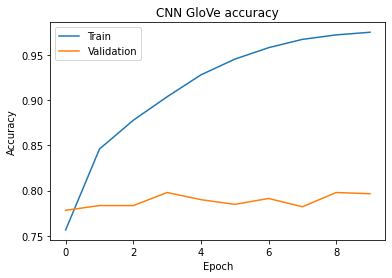

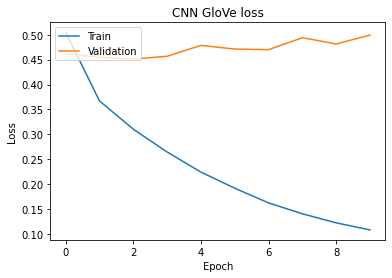

In [ ]:
# Plotar métricas
plot_graphs(cnn_glove_history, "CNN GloVe", key='acc')